In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install -U seaborn

     |████████████████████████████████| 286kB 2.7MB/s 
  Found existing installation: seaborn 0.10.1
    Uninstalling seaborn-0.10.1:
      Successfully uninstalled seaborn-0.10.1


## Credit Card Fraud Detection

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn import metrics, preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

## Exploratory data analysis

In [3]:
df = pd.read_csv('creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
# Observe the different feature type present in the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
Time      284807 non-null float64
V1        284807 non-null float64
V2        284807 non-null float64
V3        284807 non-null float64
V4        284807 non-null float64
V5        284807 non-null float64
V6        284807 non-null float64
V7        284807 non-null float64
V8        284807 non-null float64
V9        284807 non-null float64
V10       284807 non-null float64
V11       284807 non-null float64
V12       284807 non-null float64
V13       284807 non-null float64
V14       284807 non-null float64
V15       284807 non-null float64
V16       284807 non-null float64
V17       284807 non-null float64
V18       284807 non-null float64
V19       284807 non-null float64
V20       284807 non-null float64
V21       284807 non-null float64
V22       284807 non-null float64
V23       284807 non-null float64
V24       284807 non-null float64
V25       284807 non-null float64
V26  

In [9]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,1.768627e-15,9.170318e-16,-1.810658e-15,1.693438e-15,1.479045e-15,3.482336e-15,1.392007e-15,-7.528491e-16,4.328772e-16,9.049732e-16,5.085503e-16,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,1.088850e+00,1.020713e+00,9.992014e-01,9.952742e-01,9.585956e-01,9.153160e-01,8.762529e-01,8.493371e-01,8.381762e-01,8.140405e-01,7.709250e-01,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,-2.458826e+01,-4.797473e+00,-1.868371e+01,-5.791881e+00,-1.921433e+01,-4.498945e+00,-1.412985e+01,-2.516280e+01,-9.498746e+00,-7.213527e+00,-5.449772e+01,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,-5.354257e-01,-7.624942e-01,-4.055715e-01,-6.485393e-01,-4.255740e-01,-5.828843e-01,-4.680368e-01,-4.837483e-01,-4.988498e-01,-4.562989e-01,-2.117214e-01,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,-9.291738e-02,-3.275735e-02,1.400326e-01,-1.356806e-02,5.060132e-02,4.807155e-02,6.641332e-02,-6.567575e-02,-3.636312e-03,3.734823e-03,-6.248109e-02,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,4.539234e-01,7.395934e-01,6.182380e-01,6.625050e-01,4.931498e-01,6.488208e-01,5.232963e-01,3.996750e-01,5.008067e-01,4.589494e-01,1.330408e-01,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,2.374514e+01,1.201891e+01,7.848392e+00,7.126883e+00,1.052677e+01,8.877742e+00,1.731511e+01,9.253526e+00,5.041069e+00,5.591971e+00,3.942090e+01,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [10]:
# Check null values
df_null = df.isnull().mean()*100
df_null.sort_values(ascending=False).head()

Class    0.0
V14      0.0
V1       0.0
V2       0.0
V3       0.0
dtype: float64

In [11]:
classes = df['Class'].value_counts()
normal_share = classes[0]/df['Class'].count()*100
fraud_share = classes[1]/df['Class'].count()*100

print(normal_share)
print(fraud_share)

99.82725143693798
0.1727485630620034


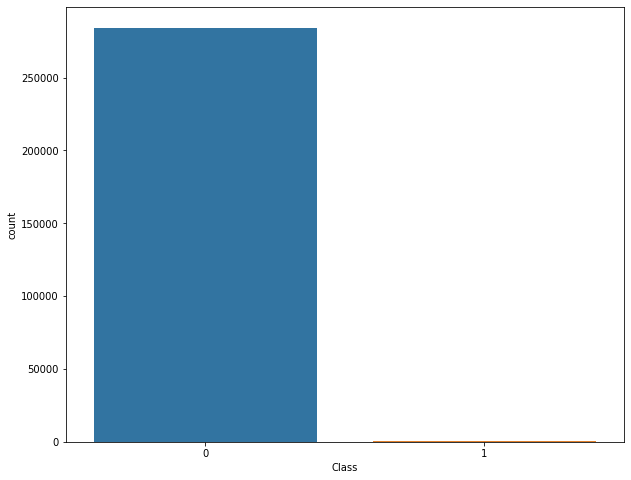

In [12]:
# Create a bar plot for the number and percentage of fraudulent vs non-fraudulent transcations
fig, ax  = plt.subplots(figsize=(10, 8))
sns.countplot(x='Class', data=df, ax=ax)

In [13]:
df_nonfraud = df[df.Class == 0]
df_fraud = df[df.Class == 1]

print(df_nonfraud.shape)
print(df_fraud.shape)

(284315, 31)
(492, 31)


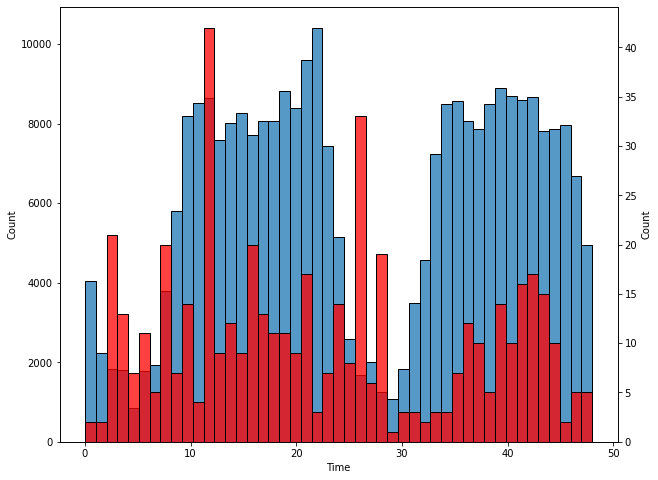

In [14]:
# Transactions by hour
bins = np.linspace(0, 48, 48)

fig, ax = plt.subplots(figsize=(10, 8))
sns.histplot(x=(df_nonfraud.Time/(60*60)), bins=bins, ax=ax)
sns.histplot(x=(df_fraud.Time/(60*60)), bins=bins, ax=ax.twinx(), color='red')

Here we can see the fraud (red) transactions happen during the night hours 2-4 AM/PM when normal (blue) transactions happen.

### Splitting the data into train & test data

In [5]:
y = df['Class'] # Target variable
X = df.drop(['Class'], axis=1)

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)

In [7]:
print(np.sum(y))
print(np.sum(y_train))
print(np.sum(y_test))

492
344
148


### Plotting the distribution of a variable

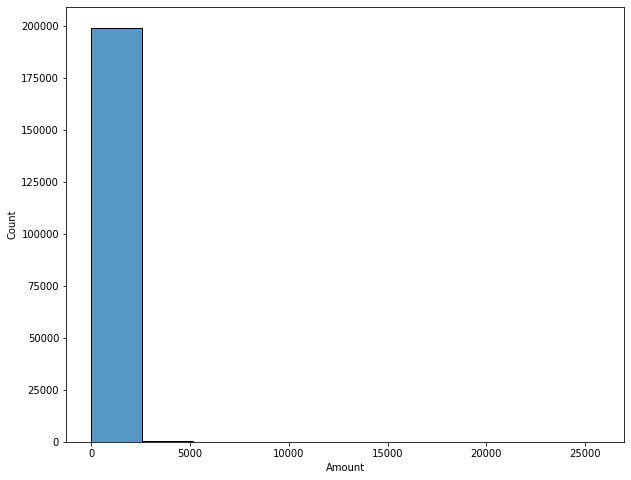

In [18]:
# plot the histogram of a variable from the dataset to see the skewness
fig, ax = plt.subplots(figsize=(10, 8))
sns.histplot(x=X_train['Amount'], bins=10, ax=ax)

### Power Transformer

In [8]:
# - Apply : preprocessing.PowerTransformer(copy=False) to fit & transform the train & test data
pt = preprocessing.PowerTransformer(copy=False)
pt.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)

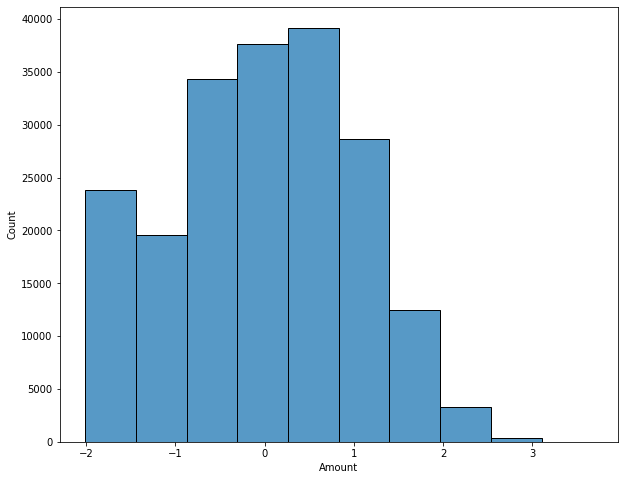

In [20]:
# plot the histogram of a variable from the dataset again to see the result 
fig, ax = plt.subplots(figsize=(10, 8))
sns.histplot(x=X_train['Amount'], bins=10, ax=ax)

# Model Building
- Build different models on the imbalanced dataset and see the result

## Logistic Regression

In [ ]:
lr_1 = LogisticRegression(random_state=100)

cv = 5
params = {
    'C': [0.1, 0.5, 1, 5, 10],
    'penalty': ['l1', 'l2']
}

In [ ]:
# perform cross validation
grid_args = {
    'estimator': lr_1,
    'cv': cv,
    'param_grid': params,
    'scoring': 'roc_auc', 
    'n_jobs': -1,
    'verbose': 1,
    'return_train_score': True
}
lr_1_cv = GridSearchCV(**grid_args)
lr_1_cv.fit(X_train, y_train)
pd.DataFrame(lr_1_cv.cv_results_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   12.8s finished


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_penalty,params,split0_test_score,split1_test_score,split2_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.112199,0.005192,0.000000,0.000000,0.1,l1,"{'C': 0.1, 'penalty': 'l1'}",NaN,NaN,NaN,...,NaN,NaN,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3.306103,0.425006,0.054601,0.013336,0.1,l2,"{'C': 0.1, 'penalty': 'l2'}",0.979357,0.970765,0.966634,...,0.976761,0.006996,1,0.979676,0.982647,0.984757,0.980738,0.978393,0.981242,0.002243
2,0.146399,0.020877,0.000000,0.000000,0.5,l1,"{'C': 0.5, 'penalty': 'l1'}",NaN,NaN,NaN,...,NaN,NaN,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4.009617,0.415812,0.052026,0.008331,0.5,l2,"{'C': 0.5, 'penalty': 'l2'}",0.978927,0.970759,0.966106,...,0.976165,0.006779,2,0.978968,0.981929,0.984186,0.980286,0.977861,0.980646,0.002230
4,0.272003,0.100822,0.000000,0.000000,1,l1,"{'C': 1, 'penalty': 'l1'}",NaN,NaN,NaN,...,NaN,NaN,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,4.065513,0.457359,0.049601,0.013588,1,l2,"{'C': 1, 'penalty': 'l2'}",0.978855,0.970748,0.966026,...,0.976066,0.006744,3,0.978856,0.981809,0.984092,0.980213,0.977775,0.980549,0.002228
6,0.195999,0.041470,0.000000,0.000000,5,l1,"{'C': 5, 'penalty': 'l1'}",NaN,NaN,NaN,...,NaN,NaN,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,3.586492,0.224076,0.038599,0.004500,5,l2,"{'C': 5, 'penalty': 'l2'}",0.978782,0.970742,0.965963,...,0.975982,0.006711,4,0.978763,0.981713,0.984014,0.980144,0.977696,0.980466,0.002228
8,0.208571,0.027370,0.000000,0.000000,10,l1,"{'C': 10, 'penalty': 'l1'}",NaN,NaN,NaN,...,NaN,NaN,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,2.927082,0.496901,0.022395,0.005963,10,l2,"{'C': 10, 'penalty': 'l2'}",0.978771,0.970740,0.965957,...,0.975971,0.006706,5,0.978750,0.981700,0.984003,0.980135,0.977687,0.980455,0.002228


In [ ]:
print('Best AUC : ', round(lr_1_cv.best_score_, 3))
print('Best hyperparameters: ', lr_1_cv.best_params_)

Best AUC :  0.977
Best hyperparameters:  {'C': 0.1, 'penalty': 'l2'}


In [ ]:
lr_1_tuned = LogisticRegression(**lr_1_cv.best_params_)
lr_1_tuned.fit(X_train, y_train)
y_pred = lr_1_tuned.predict(X_test)

In [ ]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.92      0.58      0.71       148

    accuracy                           1.00     85443
   macro avg       0.96      0.79      0.86     85443
weighted avg       1.00      1.00      1.00     85443



In [ ]:
metrics.confusion_matrix(y_test, y_pred)

array([[85288,     7],
       [   62,    86]], dtype=int64)

In [ ]:
print('Accuracy: ', metrics.accuracy_score(y_test, y_pred))
print('ROC AUC:', metrics.roc_auc_score(y_test, y_pred))

Accuracy:  0.9991924440855307
ROC AUC: 0.7904995064822722


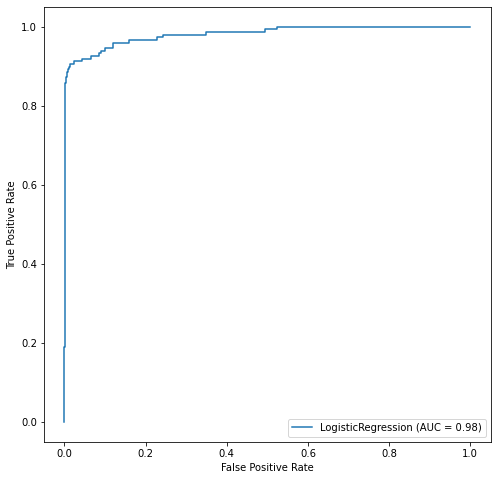

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))
metrics.plot_roc_curve(lr_1_tuned, X_test, y_test, ax=ax)

- Precision : 0.86
- Recall : 0.64
- F1-score : 0.73
- Accuracy : 0.99
- ROC AUC : 0.82

## Random Forest

In [ ]:
rf_1 = RandomForestClassifier(random_state=100)

cv = 5
params = { 
    'n_estimators': [100, 400, 1000],
    'max_depth' : [4, 6, 10, 16]
}

In [ ]:
# perform cross validation
grid_args = {
    'estimator': rf_1,
    'cv': cv,
    'param_grid': params,
    'scoring': 'roc_auc', 
    'n_jobs': -1,
    'verbose': 1,
    'return_train_score': True
}
rf_1_cv = GridSearchCV(**grid_args)
rf_1_cv.fit(X_train, y_train)
pd.DataFrame(rf_1_cv.cv_results_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed: 13.8min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed: 62.3min finished


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,64.706720,0.976508,0.386650,0.074046,4,100,"{'max_depth': 4, 'n_estimators': 100}",0.961696,0.951522,0.957727,...,0.964727,0.012052,10,0.970250,0.968714,0.969790,0.966596,0.961172,0.967304,3.315204e-03
1,261.652946,2.448989,1.503362,0.298081,4,400,"{'max_depth': 4, 'n_estimators': 400}",0.954479,0.955610,0.959698,...,0.963633,0.011796,11,0.967839,0.972149,0.972322,0.969061,0.964344,0.969143,2.962572e-03
2,653.272546,4.411632,4.081622,0.312607,4,1000,"{'max_depth': 4, 'n_estimators': 1000}",0.956500,0.953274,0.957347,...,0.962035,0.012414,12,0.973193,0.976532,0.973384,0.967993,0.966368,0.971494,3.751798e-03
3,95.852663,2.149342,0.467200,0.071001,6,100,"{'max_depth': 6, 'n_estimators': 100}",0.969685,0.967316,0.969310,...,0.971376,0.010421,7,0.979859,0.983084,0.982584,0.982871,0.980798,0.981839,1.278824e-03
4,381.695257,5.325977,1.583823,0.145863,6,400,"{'max_depth': 6, 'n_estimators': 400}",0.966972,0.963583,0.960560,...,0.969519,0.010917,8,0.986836,0.988956,0.984637,0.985861,0.984182,0.986094,1.707357e-03
5,963.027845,5.947717,4.065237,0.239501,6,1000,"{'max_depth': 6, 'n_estimators': 1000}",0.968814,0.963302,0.959359,...,0.969385,0.011119,9,0.989525,0.991607,0.987774,0.986653,0.990669,0.989246,1.820262e-03
6,158.002071,3.486015,0.579416,0.097485,10,100,"{'max_depth': 10, 'n_estimators': 100}",0.977494,0.970681,0.963048,...,0.975068,0.009899,5,0.999361,0.997293,0.998030,0.999675,0.999797,0.998832,9.933547e-04
7,628.264269,4.273077,2.038850,0.173252,10,400,"{'max_depth': 10, 'n_estimators': 400}",0.978345,0.973331,0.966361,...,0.975945,0.009530,3,0.999898,0.999815,0.999882,0.999862,0.999903,0.999872,3.195362e-05
8,1515.980709,36.978035,4.033838,0.911258,10,1000,"{'max_depth': 10, 'n_estimators': 1000}",0.979650,0.971237,0.964959,...,0.975444,0.010041,4,0.999924,0.999902,0.999881,0.999855,0.999898,0.999892,2.302506e-05
9,222.935957,2.522197,0.641247,0.064392,16,100,"{'max_depth': 16, 'n_estimators': 100}",0.981047,0.963881,0.970003,...,0.973908,0.008904,6,0.999998,0.999998,0.999997,0.999997,0.999998,0.999998,4.751205e-07


In [ ]:
print('Best AUC : ', round(rf_1_cv.best_score_, 3))
print('Best hyperparameters: ', rf_1_cv.best_params_)

Best AUC :  0.979
Best hyperparameters:  {'max_depth': 16, 'n_estimators': 400}


In [ ]:
rf_1_tuned = rm_1 = RandomForestClassifier(**rf_1_cv.best_params_, random_state=100)
rf_1_tuned.fit(X_train, y_train)
y_pred = rf_1_tuned.predict(X_test)

In [ ]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.96      0.76      0.85       148

    accuracy                           1.00     85443
   macro avg       0.98      0.88      0.92     85443
weighted avg       1.00      1.00      1.00     85443



In [ ]:
metrics.confusion_matrix(y_test, y_pred)

array([[85290,     5],
       [   35,   113]], dtype=int64)

In [ ]:
print('Accuracy: ', metrics.accuracy_score(y_test, y_pred))
print('ROC AUC:', metrics.roc_auc_score(y_test, y_pred))

Accuracy:  0.9995318516437859
ROC AUC: 0.8817274467151365


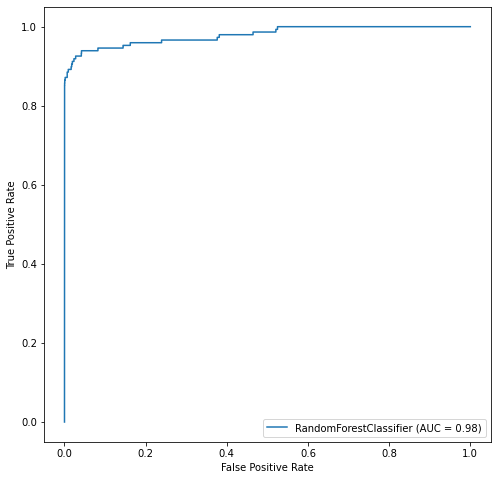

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))
metrics.plot_roc_curve(rf_1_tuned, X_test, y_test, ax=ax)

- Precision : 0.
- Recall : 0.
- F1-score : 0.
- Accuracy : 0.
- ROC AUC : 0.

## XGBoost

In [ ]:
xgb_1 = XGBClassifier(tree_method='gpu_hist', predictor='gpu_predictor', max_bins=128, random_state=100)

cv = 5
params = {
    'min_child_weight': [1, 5],
    'gamma': [0.5, 1.5, 5],
    'subsample': [0.6, 1.0],
    'colsample_bytree': [0.6, 1.0],
    'max_depth': [3, 5]
  }

In [ ]:
# perform cross validation
grid_args = {
    'estimator': xgb_1,
    'cv': cv,
    'param_grid': params,
    'scoring': 'roc_auc', 
    'n_jobs': -1,
    'verbose': 1,
    'return_train_score': True
}
xgb_1_cv = GridSearchCV(**grid_args)
xgb_1_cv.fit(X_train, y_train)
pd.DataFrame(xgb_1_cv.cv_results_)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   20.2s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:  1.6min finished


[16:07:08] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { max_bins } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_colsample_bytree,param_gamma,param_max_depth,param_min_child_weight,param_subsample,params,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,6.726684,0.108918,0.127201,0.020147,0.6,0.5,3,1,0.6,"{'colsample_bytree': 0.6, 'gamma': 0.5, 'max_d...",...,0.977292,0.012698,46,0.999998,0.999998,0.999998,0.999995,0.999992,0.999996,2.179547e-06
1,6.378481,0.184115,0.139799,0.016302,0.6,0.5,3,1,1,"{'colsample_bytree': 0.6, 'gamma': 0.5, 'max_d...",...,0.979954,0.005066,29,0.999995,0.999999,0.999984,0.999997,0.999988,0.999993,5.661058e-06
2,4.952124,1.191778,0.122409,0.020750,0.6,0.5,3,5,0.6,"{'colsample_bytree': 0.6, 'gamma': 0.5, 'max_d...",...,0.979187,0.010664,37,0.999765,0.999805,0.999876,0.999781,0.999755,0.999796,4.323309e-05
3,4.476622,0.143578,0.125311,0.015131,0.6,0.5,3,5,1,"{'colsample_bytree': 0.6, 'gamma': 0.5, 'max_d...",...,0.982980,0.006292,9,0.999965,0.999983,0.999970,0.999983,0.999972,0.999975,7.220843e-06
4,5.291803,0.163793,0.137000,0.014183,0.6,0.5,5,1,0.6,"{'colsample_bytree': 0.6, 'gamma': 0.5, 'max_d...",...,0.981837,0.007271,15,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000e+00
5,4.439301,0.085419,0.122801,0.013599,0.6,0.5,5,1,1,"{'colsample_bytree': 0.6, 'gamma': 0.5, 'max_d...",...,0.978960,0.007712,40,0.999999,1.000000,1.000000,0.999999,0.999999,1.000000,3.191998e-07
6,4.896599,0.094237,0.139800,0.014838,0.6,0.5,5,5,0.6,"{'colsample_bytree': 0.6, 'gamma': 0.5, 'max_d...",...,0.979445,0.008892,35,0.999912,0.999870,0.999833,0.999916,0.999881,0.999883,3.021747e-05
7,4.650141,0.105329,0.153311,0.018193,0.6,0.5,5,5,1,"{'colsample_bytree': 0.6, 'gamma': 0.5, 'max_d...",...,0.981562,0.006859,16,0.999997,0.999998,0.999998,0.999991,0.999998,0.999997,2.729972e-06
8,4.031447,0.143054,0.135902,0.017590,0.6,1.5,3,1,0.6,"{'colsample_bytree': 0.6, 'gamma': 1.5, 'max_d...",...,0.978235,0.007222,42,0.999994,0.999996,0.999996,0.999986,0.999983,0.999991,5.728007e-06
9,3.016887,0.609057,0.138200,0.024195,0.6,1.5,3,1,1,"{'colsample_bytree': 0.6, 'gamma': 1.5, 'max_d...",...,0.982585,0.007105,12,0.999691,0.999764,0.999815,0.999693,0.999626,0.999718,6.545657e-05


In [ ]:
print('Best AUC : ', round(xgb_1_cv.best_score_, 3))
print('Best hyperparameters: ', xgb_1_cv.best_params_)

Best AUC :  0.986
Best hyperparameters:  {'colsample_bytree': 0.6, 'gamma': 1.5, 'max_depth': 3, 'min_child_weight': 5, 'subsample': 1.0}


In [ ]:
xgb_1_tuned = XGBClassifier(**xgb_1_cv.best_params_, random_state=100)
xgb_1_tuned.fit(X_train, y_train)
y_pred = xgb_1_tuned.predict(X_test)

In [ ]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.95      0.80      0.87       148

    accuracy                           1.00     85443
   macro avg       0.98      0.90      0.93     85443
weighted avg       1.00      1.00      1.00     85443



In [ ]:
metrics.confusion_matrix(y_test, y_pred)

array([[85289,     6],
       [   30,   118]], dtype=int64)

In [ ]:
print('Accuracy: ', metrics.accuracy_score(y_test, y_pred))
print('ROC AUC:', metrics.roc_auc_score(y_test, y_pred))

Accuracy:  0.9995786664794073
ROC AUC: 0.8986134765987044


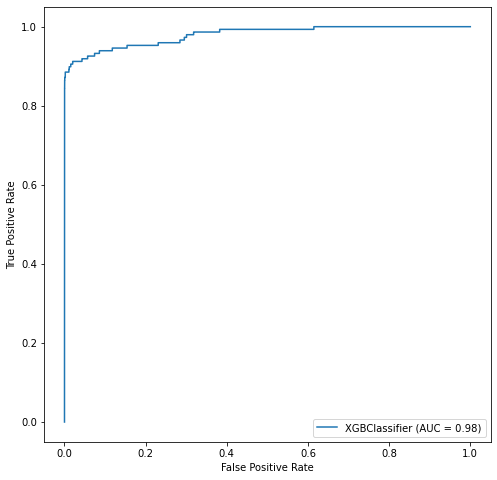

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))
metrics.plot_roc_curve(xgb_1_tuned, X_test, y_test, ax=ax)

- Precision : 0.
- Recall : 0.
- F1-score : 0.
- Accuracy : 0.
- ROC AUC : 0.

# Model building (with balanced class)

##### Perform class balancing with :
- Random Oversampling
- SMOTE
- ADASYN

## Oversampling

In [9]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN

print(f'Initial shape: {X_train.shape}')

# Resample training data
ros = RandomOverSampler()
smote = SMOTE(random_state=100)
adasyn = ADASYN(random_state=100)

X_train_ros, y_train_ros = ros.fit_sample(X_train, y_train)
print(f'ROS Shape: {X_train_ros.shape}')

X_train_smote, y_train_smote = smote.fit_sample(X_train, y_train)
print(f'SMOTE Shape: {X_train_smote.shape}')

X_train_adasyn, y_train_adasyn = adasyn.fit_sample(X_train, y_train)
print(f'ADASYN Shape: {X_train_adasyn.shape}')

Initial shape: (199364, 30)
ROS Shape: (398040, 30)
SMOTE Shape: (398040, 30)
ADASYN Shape: (398045, 30)


### Class distribution after applying SMOTE 

TypeError: '(slice(None, 344, None), 0)' is an invalid key

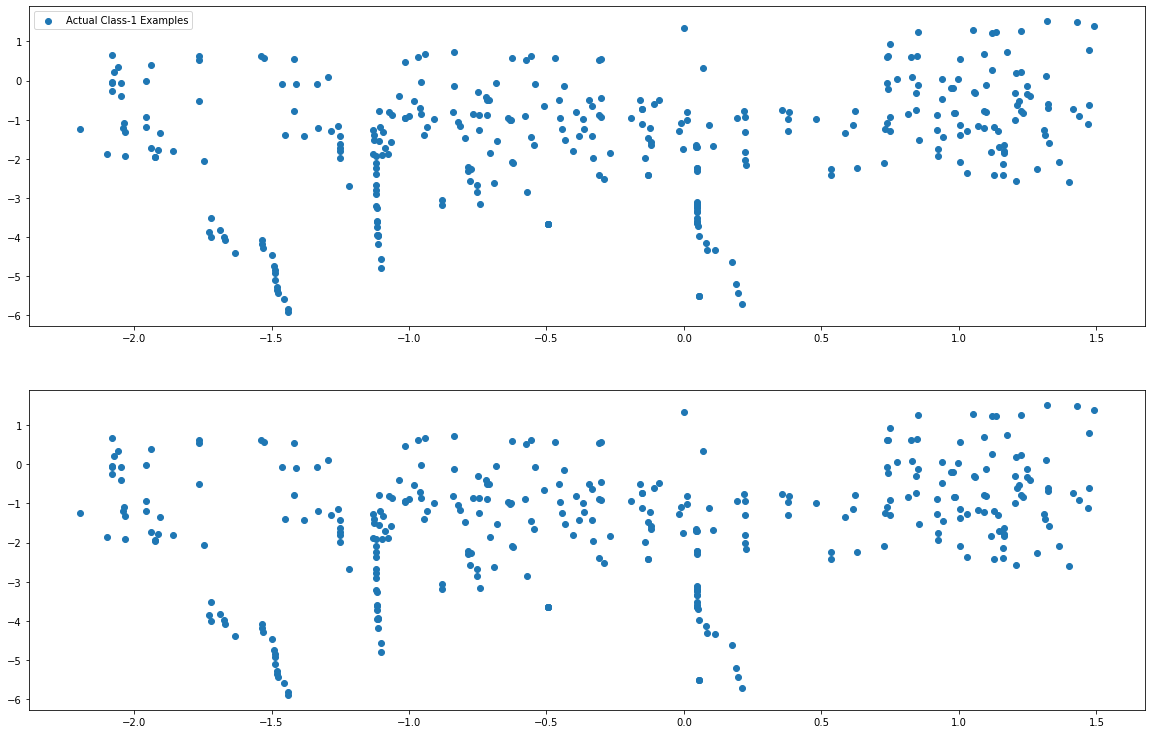

In [ ]:
import warnings
warnings.filterwarnings("ignore")

# Artificial minority samples and corresponding minority labels from SMOTE are appended
# below X_train and y_train respectively
# So to exclusively get the artificial minority samples from SMOTE, we do
X_train_smote_1 = X_train_smote[X_train.shape[0]:]

X_train_1 = X_train.to_numpy()[np.where(y_train==1.0)]
X_train_0 = X_train.to_numpy()[np.where(y_train==0.0)]

plt.rcParams['figure.figsize'] = [20, 20]
fig = plt.figure()

plt.subplot(3, 1, 1)
plt.scatter(X_train_1[:, 0], X_train_1[:, 1], label='Actual Class-1 Examples')
plt.legend()

plt.subplot(3, 1, 2)
plt.scatter(X_train_1[:, 0], X_train_1[:, 1], label='Actual Class-1 Examples')
plt.scatter(X_train_smote_1[:X_train_1.shape[0], 0], X_train_smote_1[:X_train_1.shape[0], 1],
            label='Artificial SMOTE Class-1 Examples')
plt.legend()

plt.subplot(3, 1, 3)
plt.scatter(X_train_1[:, 0], X_train_1[:, 1], label='Actual Class-1 Examples')
plt.scatter(X_train_0[:X_train_1.shape[0], 0], X_train_0[:X_train_1.shape[0], 1], label='Actual Class-0 Examples')
plt.legend()

### Class distribution after applying ADASYN

TypeError: '(slice(None, 344, None), 0)' is an invalid key

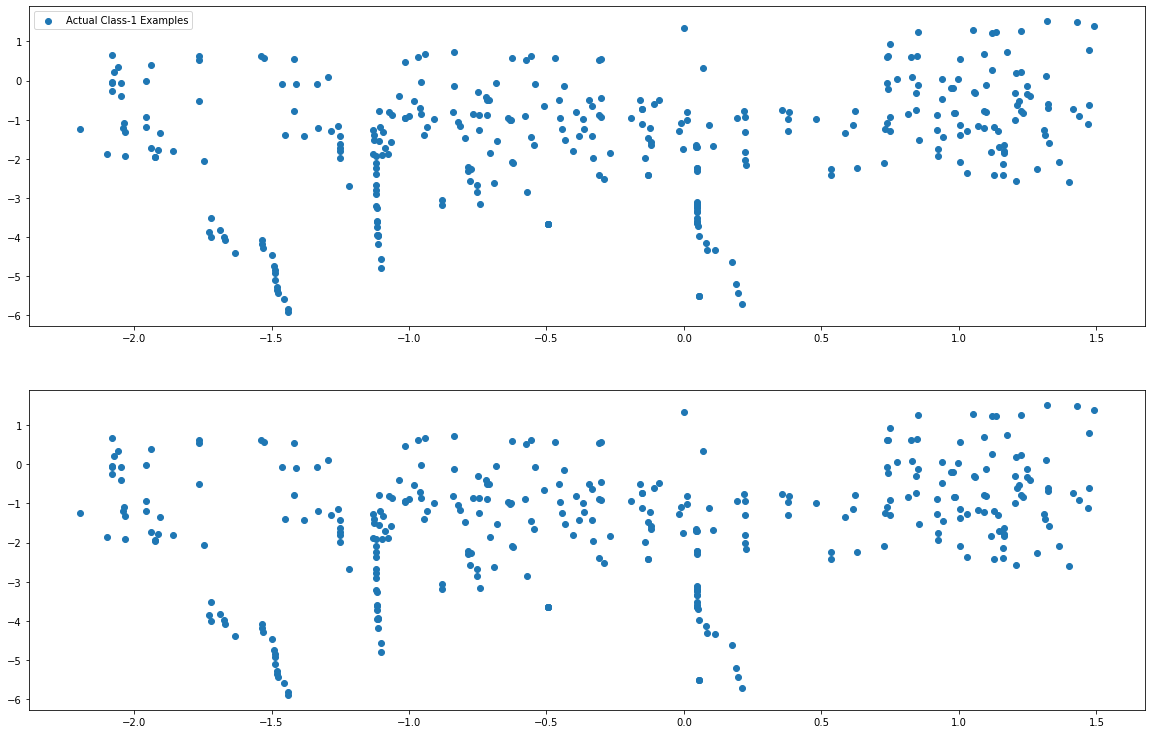

In [ ]:
# Artificial minority samples and corresponding minority labels from ADASYN are appended
# below X_train and y_train respectively
# So to exclusively get the artificial minority samples from ADASYN, we do
X_train_adasyn_1 = X_train_adasyn[X_train.shape[0]:]

X_train_1 = X_train.to_numpy()[np.where(y_train==1.0)]
X_train_0 = X_train.to_numpy()[np.where(y_train==0.0)]

plt.rcParams['figure.figsize'] = [20, 20]
fig = plt.figure()

plt.subplot(3, 1, 1)
plt.scatter(X_train_1[:, 0], X_train_1[:, 1], label='Actual Class-1 Examples')
plt.legend()

plt.subplot(3, 1, 2)
plt.scatter(X_train_1[:, 0], X_train_1[:, 1], label='Actual Class-1 Examples')
plt.scatter(X_train_adasyn_1[:X_train_1.shape[0], 0], X_train_adasyn_1[:X_train_1.shape[0], 1],
            label='Artificial ADASYN Class-1 Examples')
plt.legend()

plt.subplot(3, 1, 3)
plt.scatter(X_train_1[:, 0], X_train_1[:, 1], label='Actual Class-1 Examples')
plt.scatter(X_train_0[:X_train_1.shape[0], 0], X_train_0[:X_train_1.shape[0], 1], label='Actual Class-0 Examples')
plt.legend()

## Logistic Regression

### Random Oversampling

In [ ]:
lr_2_ros = LogisticRegression(random_state=100)
lr_2_ros.fit(X_train_ros, y_train_ros)
y_pred = lr_2_ros.predict(X_test)

              precision    recall  f1-score   support

           0       1.00      0.97      0.99     85295
           1       0.06      0.91      0.11       148

    accuracy                           0.97     85443
   macro avg       0.53      0.94      0.55     85443
weighted avg       1.00      0.97      0.99     85443

Accuracy:  0.9741933218636986
ROC AUC: 0.9432315588347596


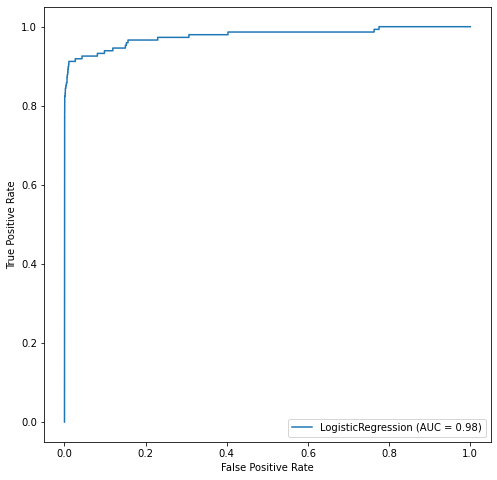

In [ ]:
print(metrics.classification_report(y_test, y_pred))
print('Accuracy: ', metrics.accuracy_score(y_test, y_pred))
print('ROC AUC:', metrics.roc_auc_score(y_test, y_pred))

fig, ax = plt.subplots(figsize=(8, 8))
metrics.plot_roc_curve(lr_2_ros, X_test, y_test, ax=ax)

- Precision : 0.06
- Recall : 0.91
- F1-score : 0.11
- Accuracy : 0.97
- ROC AUC : 0.98

### SMOTE

In [ ]:
lr_2_smote = LogisticRegression(random_state=100)
lr_2_smote.fit(X_train_smote, y_train_smote)
y_pred = lr_2_smote.predict(X_test)

              precision    recall  f1-score   support

           0       1.00      0.97      0.98     85295
           1       0.05      0.92      0.10       148

    accuracy                           0.97     85443
   macro avg       0.53      0.94      0.54     85443
weighted avg       1.00      0.97      0.98     85443

Accuracy:  0.9699214681132451
ROC AUC: 0.9444644421665349


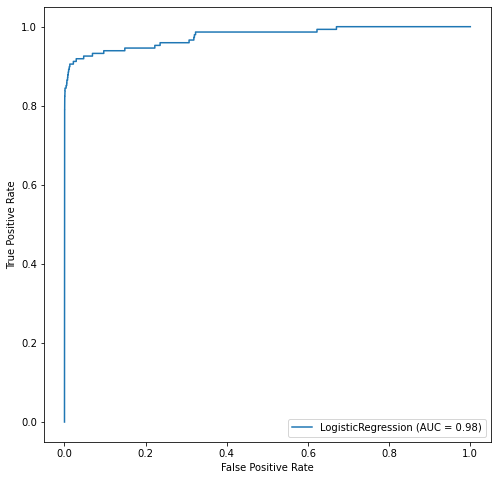

In [ ]:
print(metrics.classification_report(y_test, y_pred))
print('Accuracy: ', metrics.accuracy_score(y_test, y_pred))
print('ROC AUC:', metrics.roc_auc_score(y_test, y_pred))

fig, ax = plt.subplots(figsize=(8, 8))
metrics.plot_roc_curve(lr_2_smote, X_test, y_test, ax=ax)

- Precision : 0.05
- Recall : 0.91
- F1-score : 0.10
- Accuracy : 0.97
- ROC AUC : 0.94

### ADASYN

In [ ]:
lr_2_adasyn = LogisticRegression(random_state=100)
lr_2_adasyn.fit(X_train_adasyn, y_train_adasyn)
y_pred = lr_2_adasyn.predict(X_test)

              precision    recall  f1-score   support

           0       1.00      0.92      0.96     85295
           1       0.02      0.93      0.04       148

    accuracy                           0.92     85443
   macro avg       0.51      0.92      0.50     85443
weighted avg       1.00      0.92      0.96     85443

Accuracy:  0.9188581861591939
ROC AUC: 0.9222610162187511


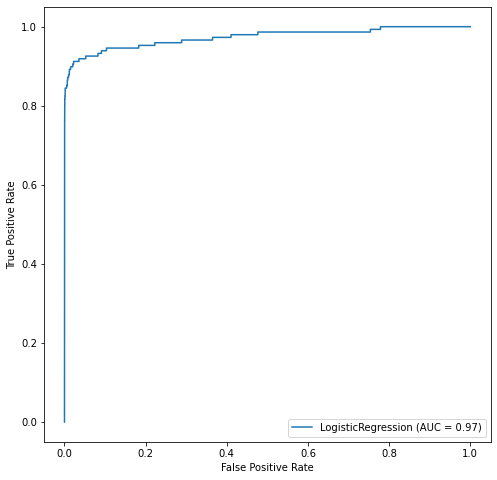

In [ ]:
print(metrics.classification_report(y_test, y_pred))
print('Accuracy: ', metrics.accuracy_score(y_test, y_pred))
print('ROC AUC:', metrics.roc_auc_score(y_test, y_pred))

fig, ax = plt.subplots(figsize=(8, 8))
metrics.plot_roc_curve(lr_2_adasyn, X_test, y_test, ax=ax)

- Precision : 0.02
- Recall : 0.95
- F1-score : 0.04
- Accuracy : 0.91
- ROC AUC : 0.93

### Hyperparameter Tuning

In [ ]:
lr_2 = LogisticRegression(random_state=100)

cv = 5
params = {
    'C': [0.1, 0.5, 1, 5, 10],
    'penalty': ['l1', 'l2']
}

# perform cross validation
grid_args = {
    'estimator': lr_2,
    'cv': cv,
    'param_grid': params,
    'scoring': 'roc_auc', 
    'n_jobs': -1,
    'verbose': 1,
    'return_train_score': True
}
lr_2_cv = GridSearchCV(**grid_args)
lr_2_cv.fit(X_train_ros, y_train_ros)

print('Best AUC : ', round(lr_2_cv.best_score_, 3))
print('Best hyperparameters: ', lr_2_cv.best_params_)

lr_2_tuned = LogisticRegression(**lr_2_cv.best_params_)
lr_2_tuned.fit(X_train, y_train)
y_pred = lr_2_tuned.predict(X_test)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   12.5s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   22.8s finished


Best AUC :  0.988
Best hyperparameters:  {'C': 10, 'penalty': 'l2'}


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.93      0.59      0.72       148

    accuracy                           1.00     85443
   macro avg       0.96      0.79      0.86     85443
weighted avg       1.00      1.00      1.00     85443

Accuracy:  0.999204147794436
ROC AUC: 0.7938778848606505


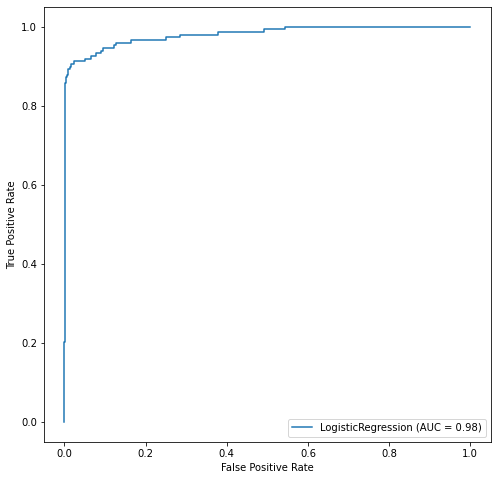

In [ ]:
print(metrics.classification_report(y_test, y_pred))
print('Accuracy: ', metrics.accuracy_score(y_test, y_pred))
print('ROC AUC:', metrics.roc_auc_score(y_test, y_pred))

fig, ax = plt.subplots(figsize=(8, 8))
metrics.plot_roc_curve(lr_2_tuned, X_test, y_test, ax=ax)

## Random Forest

### Random Oversampling

In [ ]:
rf_2_ros = RandomForestClassifier(random_state=100)
rf_2_ros.fit(X_train_ros, y_train_ros)
y_pred = rf_2_ros.predict(X_test)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.96      0.77      0.85       148

    accuracy                           1.00     85443
   macro avg       0.98      0.89      0.93     85443
weighted avg       1.00      1.00      1.00     85443

Accuracy:  0.9995435553526912
ROC AUC: 0.8851058250935148


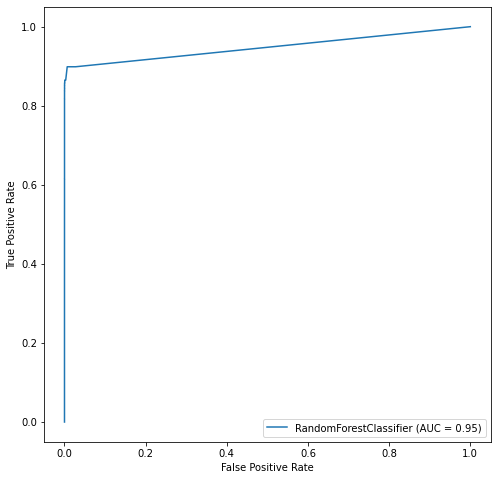

In [ ]:
print(metrics.classification_report(y_test, y_pred))
print('Accuracy: ', metrics.accuracy_score(y_test, y_pred))
print('ROC AUC:', metrics.roc_auc_score(y_test, y_pred))

fig, ax = plt.subplots(figsize=(8, 8))
metrics.plot_roc_curve(rf_2_ros, X_test, y_test, ax=ax)

- Precision : 0.06
- Recall : 0.91
- F1-score : 0.11
- Accuracy : 0.97
- ROC AUC : 0.98

### SMOTE

In [ ]:
rf_2_smote = RandomForestClassifier(random_state=100)
rf_2_smote.fit(X_train_smote, y_train_smote)
y_pred = rf_2_smote.predict(X_test)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.91      0.80      0.85       148

    accuracy                           1.00     85443
   macro avg       0.95      0.90      0.93     85443
weighted avg       1.00      1.00      1.00     85443

Accuracy:  0.9995201479348805
ROC AUC: 0.9019566829271384


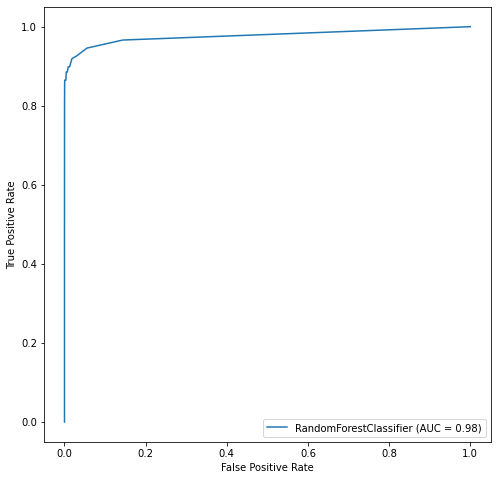

In [ ]:
print(metrics.classification_report(y_test, y_pred))
print('Accuracy: ', metrics.accuracy_score(y_test, y_pred))
print('ROC AUC:', metrics.roc_auc_score(y_test, y_pred))

fig, ax = plt.subplots(figsize=(8, 8))
metrics.plot_roc_curve(rf_2_smote, X_test, y_test, ax=ax)

- Precision : 0.05
- Recall : 0.91
- F1-score : 0.10
- Accuracy : 0.97
- ROC AUC : 0.94

### ADASYN

In [ ]:
rf_2_adasyn = RandomForestClassifier(random_state=100)
rf_2_adasyn.fit(X_train_adasyn, y_train_adasyn)
y_pred = rf_2_adasyn.predict(X_test)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.91      0.79      0.84       148

    accuracy                           1.00     85443
   macro avg       0.95      0.90      0.92     85443
weighted avg       1.00      1.00      1.00     85443

Accuracy:  0.9994967405170698
ROC AUC: 0.8951999261703817


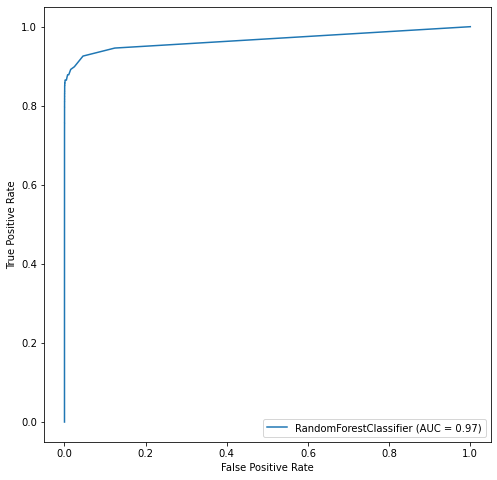

In [ ]:
print(metrics.classification_report(y_test, y_pred))
print('Accuracy: ', metrics.accuracy_score(y_test, y_pred))
print('ROC AUC:', metrics.roc_auc_score(y_test, y_pred))

fig, ax = plt.subplots(figsize=(8, 8))
metrics.plot_roc_curve(rf_2_adasyn, X_test, y_test, ax=ax)

- Precision : 0.02
- Recall : 0.95
- F1-score : 0.04
- Accuracy : 0.91
- ROC AUC : 0.93

### Hyperparameter Tuning

In [ ]:
rf_2 = RandomForestClassifier(random_state=100)

cv = 5
params = { 
    'n_estimators': [100, 300, 600],
    'max_depth' : [4, 8, 16]
}

# perform cross validation
grid_args = {
    'estimator': rf_2,
    'cv': cv,
    'param_grid': params,
    'scoring': 'roc_auc', 
    'n_jobs': -1,
    'verbose': 1,
    'return_train_score': True
}
rf_2_cv = GridSearchCV(**grid_args)
rf_2_cv.fit(X_train_ros, y_train_ros)

print('Best AUC : ', round(rf_2_cv.best_score_, 3))
print('Best hyperparameters: ', rf_2_cv.best_params_)

rf_2_tuned = RandomForestClassifier(**rf_2_cv.best_params_)
rf_2_tuned.fit(X_train, y_train)
y_pred = rf_2_tuned.predict(X_test)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed: 39.0min finished


Best AUC :  1.0
Best hyperparameters:  {'max_depth': 16, 'n_estimators': 300}


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.96      0.78      0.86       148

    accuracy                           1.00     85443
   macro avg       0.98      0.89      0.93     85443
weighted avg       1.00      1.00      1.00     85443

Accuracy:  0.9995552590615966
ROC AUC: 0.8884842034718932


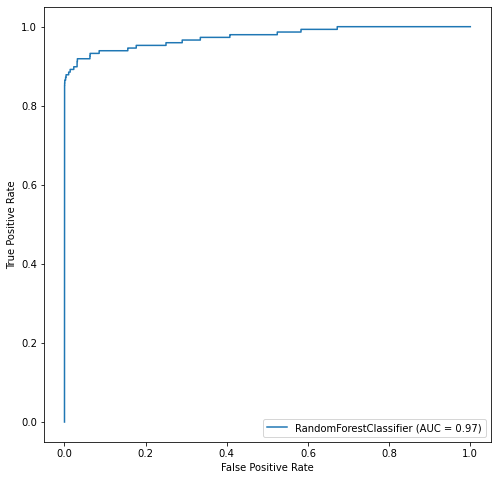

In [ ]:
print(metrics.classification_report(y_test, y_pred))
print('Accuracy: ', metrics.accuracy_score(y_test, y_pred))
print('ROC AUC:', metrics.roc_auc_score(y_test, y_pred))

fig, ax = plt.subplots(figsize=(8, 8))
metrics.plot_roc_curve(rf_2_tuned, X_test, y_test, ax=ax)

## XGBoost

### Random Oversampling

In [ ]:
xgb_2_ros = XGBClassifier(tree_method='gpu_hist', predictor='gpu_predictor', max_bins=128, random_state=100)
xgb_2_ros.fit(X_train_ros, y_train_ros)
y_pred = xgb_2_ros.predict(X_test)

[18:10:18] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { max_bins } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.93      0.82      0.87       148

    accuracy                           1.00     85443
   macro avg       0.97      0.91      0.94     85443
weighted avg       1.00      1.00      1.00     85443

Accuracy:  0.9995903701883126
ROC AUC: 0.9121094040872457


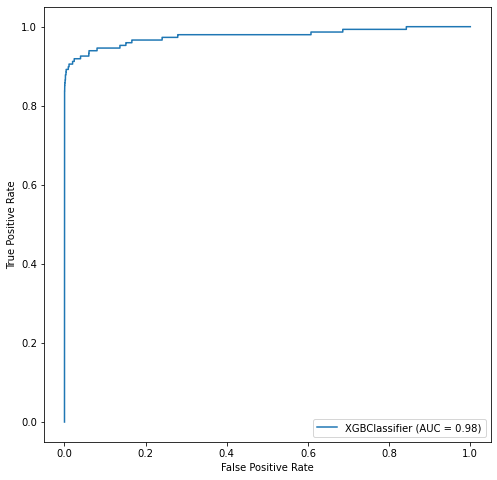

In [ ]:
print(metrics.classification_report(y_test, y_pred))
print('Accuracy: ', metrics.accuracy_score(y_test, y_pred))
print('ROC AUC:', metrics.roc_auc_score(y_test, y_pred))

fig, ax = plt.subplots(figsize=(8, 8))
metrics.plot_roc_curve(xgb_2_ros, X_test, y_test, ax=ax)

- Precision : 0.06
- Recall : 0.91
- F1-score : 0.11
- Accuracy : 0.97
- ROC AUC : 0.98

### SMOTE

In [ ]:
xgb_2_smote = XGBClassifier(tree_method='gpu_hist', predictor='gpu_predictor', max_bins=128, random_state=100)
xgb_2_smote.fit(X_train_smote, y_train_smote)
y_pred = xgb_2_smote.predict(X_test)

[18:10:20] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { max_bins } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.83      0.83      0.83       148

    accuracy                           1.00     85443
   macro avg       0.91      0.92      0.91     85443
weighted avg       1.00      1.00      1.00     85443

Accuracy:  0.999403110845827
ROC AUC: 0.9153881283241152


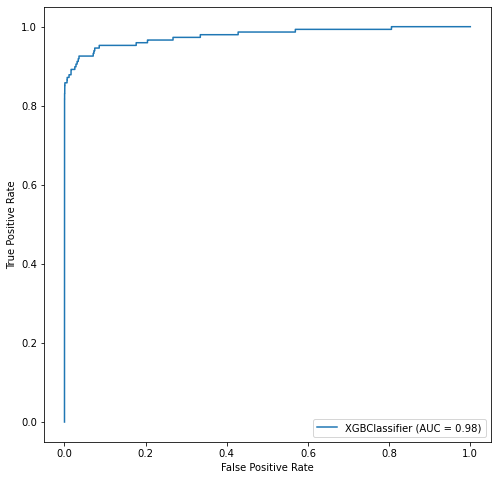

In [ ]:
print(metrics.classification_report(y_test, y_pred))
print('Accuracy: ', metrics.accuracy_score(y_test, y_pred))
print('ROC AUC:', metrics.roc_auc_score(y_test, y_pred))

fig, ax = plt.subplots(figsize=(8, 8))
metrics.plot_roc_curve(xgb_2_smote, X_test, y_test, ax=ax)

- Precision : 0.05
- Recall : 0.91
- F1-score : 0.10
- Accuracy : 0.97
- ROC AUC : 0.94

### ADASYN

In [ ]:
xgb_2_adasyn = XGBClassifier(tree_method='gpu_hist', predictor='gpu_predictor', max_bins=128, random_state=100)
xgb_2_adasyn.fit(X_train_adasyn, y_train_adasyn)
y_pred = xgb_2_adasyn.predict(X_test)

[18:10:22] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { max_bins } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.80      0.83      0.81       148

    accuracy                           1.00     85443
   macro avg       0.90      0.92      0.91     85443
weighted avg       1.00      1.00      1.00     85443

Accuracy:  0.9993445923013002
ROC AUC: 0.915358818282495


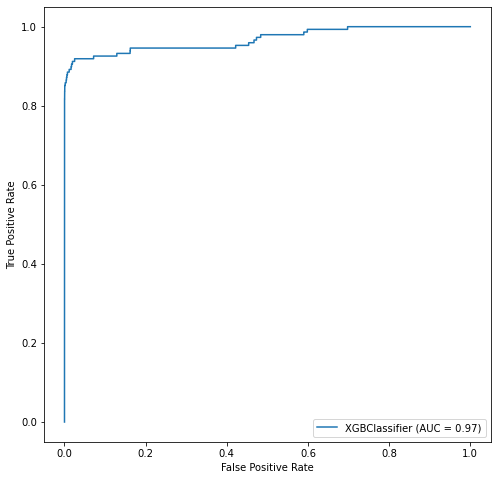

In [ ]:
print(metrics.classification_report(y_test, y_pred))
print('Accuracy: ', metrics.accuracy_score(y_test, y_pred))
print('ROC AUC:', metrics.roc_auc_score(y_test, y_pred))

fig, ax = plt.subplots(figsize=(8, 8))
metrics.plot_roc_curve(xgb_2_adasyn, X_test, y_test, ax=ax)

- Precision : 0.02
- Recall : 0.95
- F1-score : 0.04
- Accuracy : 0.91
- ROC AUC : 0.93

### Hyperparameter Tuning

In [10]:
xgb_2 = XGBClassifier(tree_method='gpu_hist', predictor='gpu_predictor', max_bins=128, random_state=100)

cv = 5
params = {
    'min_child_weight': [1, 5],
    'gamma': [0.5, 1.5, 5],
    'subsample': [0.6, 1.0],
    'colsample_bytree': [0.6, 1.0],
    'max_depth': [3, 5]
}

# perform cross validation
grid_args = {
    'estimator': xgb_2,
    'cv': cv,
    'param_grid': params,
    'scoring': 'roc_auc', 
    'n_jobs': -1,
    'verbose': 1,
    'return_train_score': True
}
xgb_2_cv = GridSearchCV(**grid_args)
xgb_2_cv.fit(X_train_smote, y_train_smote)

print('Best AUC : ', round(xgb_2_cv.best_score_, 3))
print('Best hyperparameters: ', xgb_2_cv.best_params_)

xgb_2_tuned = XGBClassifier(**xgb_2_cv.best_params_)
xgb_2_tuned.fit(X_train_smote, y_train_smote)
y_pred = xgb_2_tuned.predict(X_test)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   31.3s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:  3.0min finished


[22:57:40] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { max_bins } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Best AUC :  1.0
Best hyperparameters:  {'colsample_bytree': 1.0, 'gamma': 1.5, 'max_depth': 5, 'min_child_weight': 5, 'subsample': 0.6}


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.64      0.83      0.72       148

    accuracy                           1.00     85443
   macro avg       0.82      0.92      0.86     85443
weighted avg       1.00      1.00      1.00     85443

Accuracy:  0.9988881476539916
ROC AUC: 0.9151301999578569


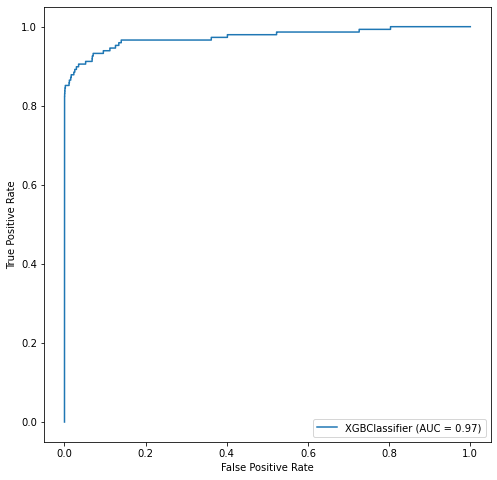

In [11]:
print(metrics.classification_report(y_test, y_pred))
print('Accuracy: ', metrics.accuracy_score(y_test, y_pred))
print('ROC AUC:', metrics.roc_auc_score(y_test, y_pred))

fig, ax = plt.subplots(figsize=(8, 8))
metrics.plot_roc_curve(xgb_2_tuned, X_test, y_test, ax=ax)

# Model Selection & Evaluation
We will go with XGBoost with SMOTE applied since it gives a good balance of recall and precision.

## Important features of the best model

Top var = 15
2nd Top var = 5
3rd Top var = 9


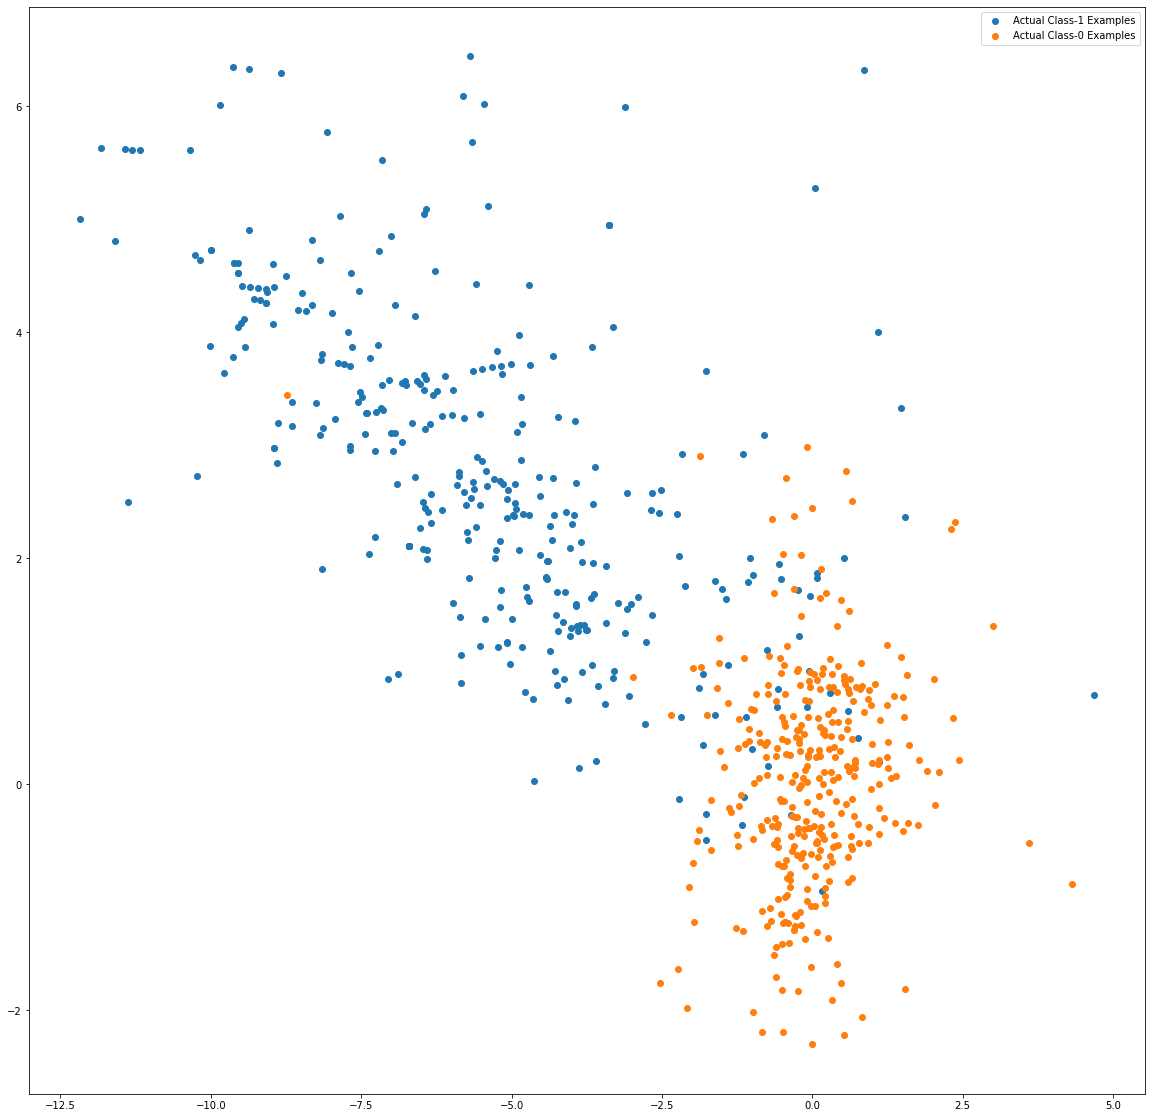

In [12]:
clf = xgb_2_tuned
var_imp = []

for i in clf.feature_importances_:
    var_imp.append(i)
    
print('Top var =', var_imp.index(np.sort(clf.feature_importances_)[-1])+1)
print('2nd Top var =', var_imp.index(np.sort(clf.feature_importances_)[-2])+1)
print('3rd Top var =', var_imp.index(np.sort(clf.feature_importances_)[-3])+1)

# Variable on Index-13 and Index-9 seems to be the top 2 variables
top_var_index = var_imp.index(np.sort(clf.feature_importances_)[-1])
second_top_var_index = var_imp.index(np.sort(clf.feature_importances_)[-2])

X_train_1 = X_train.to_numpy()[np.where(y_train==1.0)]
X_train_0 = X_train.to_numpy()[np.where(y_train==0.0)]

np.random.shuffle(X_train_0)

plt.rcParams['figure.figsize'] = [20, 20]

plt.scatter(X_train_1[:, top_var_index], X_train_1[:, second_top_var_index], label='Actual Class-1 Examples')
plt.scatter(X_train_0[:X_train_1.shape[0], top_var_index], X_train_0[:X_train_1.shape[0], second_top_var_index],label='Actual Class-0 Examples')
plt.legend()

In [ ]:
#### Print the FPR,TPR & select the best threshold from the roc curve

In [13]:
print('Accuracy: ', metrics.accuracy_score(y_test, y_pred))
print('ROC AUC:', metrics.roc_auc_score(y_test, y_pred))

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
print(thresholds[np.argmax(tpr - fpr)])

Accuracy:  0.9988881476539916
ROC AUC: 0.9151301999578569
1


# Conclusion
- Best model is XGBoost
- Best oversampling technique is SMOTE
- Top features are V15 and V5